In [9]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import scipy


In [30]:
def gaussian1d(sigma, mean, x, ord):
    x = np.array(x)
    x_ = x - mean
    var = sigma**2

    # Gaussian Function
    g1 = (1/np.sqrt(2*np.pi*var))*(np.exp((-1*x_*x_)/(2*var)))
    
    if ord == 0:
        g = g1
        return g
    elif ord == 1:
        g = -g1*((x_)/(var))
        return g
    else:
        g = g1*(((x_*x_) - var)/(var**2))
        return g

In [31]:
def gaussian2d(sup, scales):
    var = scales * scales
    shape = (sup,sup)
    n,m = [(i - 1)/2 for i in shape]
    x,y = np.ogrid[-m:m+1,-n:n+1]
    g = (1/np.sqrt(2*np.pi*var))*np.exp( -(x*x + y*y) / (2*var) )
    return g

In [32]:
def log2d(sup, scales):
    var = scales * scales
    shape = (sup,sup)
    n,m = [(i - 1)/2 for i in shape]
    x,y = np.ogrid[-m:m+1,-n:n+1]
    g = (1/np.sqrt(2*np.pi*var))*np.exp( -(x*x + y*y) / (2*var) )
    h = g*((x*x + y*y) - var)/(var**2)
    return h

In [33]:
def makefilter(scale, phasex, phasey, pts, sup):

    gx = gaussian1d(3*scale, 0, pts[0,...], phasex)
    gy = gaussian1d(scale,   0, pts[1,...], phasey)

    image = gx*gy

    image = np.reshape(image,(sup,sup))
    return image

In [34]:
def makeLMfilters(sup, scales, norient, nrotinv):
#     sup     = 49
    scalex  = np.sqrt(2) * np.arange(1,scales+1)
#     norient = 6
#     nrotinv = 12

    nbar  = len(scalex)*norient
    nedge = len(scalex)*norient
    nf    = nbar+nedge+nrotinv
    F     = np.zeros([sup,sup,nf])
    hsup  = (sup - 1)/2

    x = [np.arange(-hsup,hsup+1)]
    y = [np.arange(-hsup,hsup+1)]

    [x,y] = np.meshgrid(x,y)

    orgpts = [x.flatten(), y.flatten()]
    orgpts = np.array(orgpts)
    
    count = 0
    for scale in range(len(scalex)):
        for orient in range(norient):
            angle = (np.pi * orient)/norient
            c = np.cos(angle)
            s = np.sin(angle)
            rotpts = [[c+0,-s+0],[s+0,c+0]]
            rotpts = np.array(rotpts)
            rotpts = np.dot(rotpts,orgpts)
            F[:,:,count] = makefilter(scalex[scale], 0, 1, rotpts, sup)
            F[:,:,count+nedge] = makefilter(scalex[scale], 0, 2, rotpts, sup)
            count = count + 1
            
    count = nbar+nedge
    scales = np.sqrt(2) * np.array([1,2,3,4])
    
    for i in range(len(scales)):
        F[:,:,count]   = gaussian2d(sup, scales[i])
        count = count + 1
        
    for i in range(len(scales)):
        F[:,:,count] = log2d(sup, scales[i])
        count = count + 1
        
    for i in range(len(scales)):
        F[:,:,count] = log2d(sup, 3*scales[i])
        count = count + 1
        
    return F

In [35]:
F = makeLMfilters(49,3,6,12)
print F.shape

(49, 49, 48)


In [36]:
np.arange(1,3)

array([1, 2])

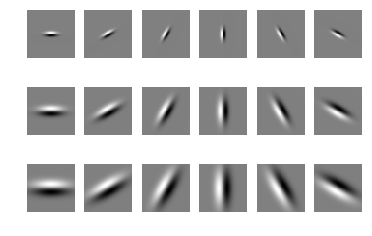

In [37]:
# First order derivative Gaussian
for i in range(0,18):
    plt.subplot(3,6,i+1)
    plt.axis('off')
    plt.imshow(F[:,:,i], cmap = 'gray')

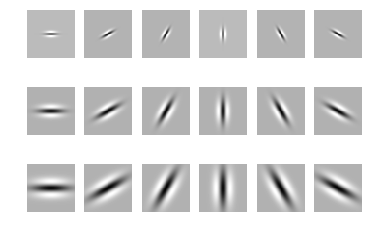

In [38]:
#Second order derivative
for i in range(0,18):
    plt.subplot(3,6,i+1)
    plt.axis('off')
    plt.imshow(F[:,:,i+18], cmap = 'gray')

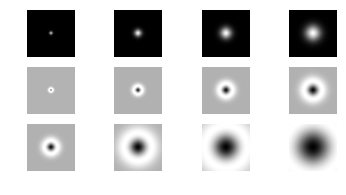

In [39]:
# Gaussian and Laplacian Filter
for i in range(0,12):
    plt.subplot(4,4,i+1)
    plt.axis('off')
    plt.imshow(F[:,:,i+36], cmap = 'gray')

In [129]:
import numpy as np
import scipy.stats as st
import skimage.transform
import cv2
def gauss2D(kernlen, scales):
    """Returns a 2D Gaussian kernel array."""
    nsig = scales*scales
    interval = (2*nsig+1.)/(kernlen)
    x = np.linspace(-nsig-interval/2., nsig+interval/2., kernlen+1)
    kern1d = np.diff(st.norm.cdf(x))
    kernel_raw = np.sqrt(np.outer(kern1d, kern1d))
    kernel = kernel_raw/kernel_raw.sum()
    return kernel
def makeDOGFilters1(scales,orient,size):
    scale = range(1,scales+1)
    orients=np.linspace(0,360,orient)
    ker = list()
    for each in scale:
        kernel=gauss2D(kernlen = size, scales = each)
        border = cv2.borderInterpolate(0, 1, cv2.BORDER_CONSTANT)
        sobelx64f = cv2.Sobel(kernel,cv2.CV_64F,1,0,ksize=5, borderType=border)
        for i,eachOrient in enumerate(orients):
#             plt.figure(figsize=(16,2))
            image=skimage.transform.rotate(sobelx64f,eachOrient)
#             plt.subplots_adjust(hspace=0.3,wspace=0.5)
#             plt.subplot(scales,orient,i+1)
#             plt.imshow(image,cmap='binary')
            ker.append(image)
            image=0
            
    return ker

def makeDOGFilters(scales,orient,size):
    orients=np.linspace(0,360,orient)
    kernels=[]
    kernel=gauss2D(size,scales)
    border = cv2.borderInterpolate(0, 1, cv2.BORDER_CONSTANT)
    sobelx64f = cv2.Sobel(kernel,cv2.CV_64F,1,0,ksize=5, borderType=border)
    for i,eachOrient in enumerate(orients):
        #plt.figure(figsize=(16,16))
        image=skimage.transform.rotate(sobelx64f,eachOrient)
        #plt.subplots_adjust(hspace=0.1,wspace=1.5)
        #plt.subplot(scales,orient,i+1)
        #plt.imshow(image,cmap='binary')
        kernels.append(image)
        image=0
    return kernels

    
#makeDOGFilters(16,15,49)

In [130]:
def gabor_fn(sigma, theta, Lambda, psi, gamma):
    """
    sigma is the variance
    theta is the orientation
    lambda is the wavelength of the sinusoidal carrier
    psi = 
    """
    sigma_x = sigma
    sigma_y = float(sigma) / gamma

    # Bounding box
    nstds = 3 # Number of standard deviation sigma
    xmax = max(abs(nstds * sigma_x * np.cos(theta)), abs(nstds * sigma_y * np.sin(theta)))
    xmax = np.ceil(max(1, xmax))
    ymax = max(abs(nstds * sigma_x * np.sin(theta)), abs(nstds * sigma_y * np.cos(theta)))
    ymax = np.ceil(max(1, ymax))
#     xmax = 15
#     ymax = 15
    xmin = -xmax
    ymin = -ymax
    (y, x) = np.meshgrid(np.arange(ymin, ymax + 1), np.arange(xmin, xmax + 1))

    # Rotation 
    x_theta = x * np.cos(theta) + y * np.sin(theta)
    y_theta = -x * np.sin(theta) + y * np.cos(theta)

    gb = np.exp(-.5 * (x_theta ** 2 / sigma_x ** 2 + y_theta ** 2 / sigma_y ** 2)) * np.cos(2 * np.pi / Lambda * x_theta + psi)
#     plt.imshow(gb,cmap='binary')
    return gb
#4, 0.25, 1, 1.0, 1
def makeGaborFilters(sigma, theta, Lambda, psi, gamma,num_filters):
    gb = gabor_fn(sigma, theta, Lambda, psi, gamma)
    g = list()
    for i in range(num_filters):
        image = skimage.transform.rotate(gb,(np.pi*i/3))
        g.append(image)
    return g
    

In [167]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import sklearn.cluster 

path = '/home/abhinav/CMSC-733/Abhi1625_hw0/Phase1/BSDS500/Images/4.jpg'
img = cv2.imread('/home/abhinav/CMSC-733/Abhi1625_hw0/Phase1/BSDS500/Images/1.jpg',0)  #0 for reading img in grayscale

filter_bank1 = makeLMfilters(sup = 49, scales = 3, norient = 6, nrotinv = 12)
filter_bank2 = makeDOGFilters(scales = 16,orient = 15, size = 49 )
filter_bank3 = makeGaborFilters(sigma=4, theta=0.25, Lambda=1, psi=1, gamma=1,num_filters=15)

In [184]:
def texton_DOG(Img, filter_bank = filter_bank2):
    tex_map = np.array(Img)
#     _,_,num_filters = filter_bank.shape
    num_filters = len(filter_bank)
    for i in range(num_filters):
#         out = cv2.filter2D(img,-1,filter_bank[:,:,i])
        out = cv2.filter2D(Img,-1,filter_bank[i])
        tex_map = np.dstack((tex_map, out))
    return tex_map
def texton_LM(Img, filter_bank = filter_bank2):
    tex_map = np.array(Img)
    _,_,num_filters = filter_bank.shape
#     num_filters = len(filter_bank)
    for i in range(num_filters):
        out = cv2.filter2D(Img,-1,filter_bank[:,:,i])
#         out = cv2.filter2D(img,-1,filter_bank[i])
        tex_map = np.dstack((tex_map, out))
    return tex_map

def clustering(img,filter_bank1,filter_bank2,filter_bank3, num_clusters):
    p,q,_ = img.shape
    tex_map_DOG = texton_DOG(img, filter_bank2)
    tex_map_LM = texton_LM(img, filter_bank1)
    tex_map_Gabor = texton_DOG(img, filter_bank3)
    tex_map = np.dstack((tex_map_DOG,tex_map_LM,tex_map_Gabor))
    m,n,r = tex_map.shape
    inp = np.reshape(tex_map,((p*q),r))
    kmeans = sklearn.cluster.KMeans(n_clusters = 64, random_state = 2)
    kmeans.fit(inp)
    labels = kmeans.predict(inp)
    l = np.reshape(labels,(m,n))
    plt.imshow(l, cmap = 'rgb')
    return l

In [185]:
clustering(img,filter_bank1,filter_bank2,filter_bank3,num_clusters=64)

KeyboardInterrupt: 

In [181]:
def brightness(Img, num_clusters):
    p,q = Img.shape
    inp = np.reshape(Img,((p*q),1))
    kmeans = sklearn.cluster.KMeans(n_clusters = num_clusters, random_state = 2)
    kmeans.fit(inp)
    labels = kmeans.predict(inp)
    l = np.reshape(labels,(p,q))
    plt.imshow(l,cmap = 'binary')
    return l  

/usr/lib/python2.7/dist-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype uint8 was converted to float64.
  warnings.warn(msg, DataConversionWarning)


array([[10, 10, 10, ...,  2,  2,  2],
       [ 2,  2,  2, ...,  2,  2, 10],
       [ 2,  2,  2, ..., 10, 10, 10],
       ...,
       [ 5, 11,  5, ..., 14,  3,  1],
       [ 2,  6, 11, ...,  3, 14,  6],
       [13,  9, 11, ...,  1, 10,  0]], dtype=int32)

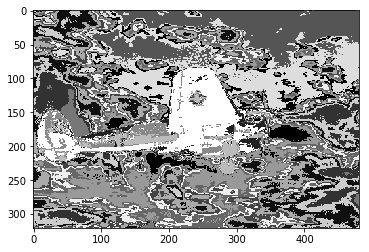

In [173]:
brightness(Img = img, num_clusters=16)

In [175]:
img = cv2.imread('/home/abhinav/CMSC-733/Abhi1625_hw0/Phase1/BSDS500/Images/1.jpg')  #0 for reading img in grayscale
def color(Img, num_clusters):
    p,q,r = Img.shape
    inp = np.reshape(Img,((p*q),r))
    kmeans = sklearn.cluster.KMeans(n_clusters = num_clusters, random_state = 2)
    kmeans.fit(inp)
    labels = kmeans.predict(inp)
    l = np.reshape(labels,(p,q))
    plt.imshow(l,cmap = 'binary')
    return l 

/usr/lib/python2.7/dist-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype uint8 was converted to float64.
  warnings.warn(msg, DataConversionWarning)


array([[ 1,  1,  1, ...,  9,  9,  9],
       [ 1,  1,  9, ...,  9,  9,  1],
       [ 9,  9,  9, ...,  1,  1,  1],
       ...,
       [10, 13, 10, ..., 10,  6,  4],
       [ 7,  7, 13, ...,  0,  0,  7],
       [12, 11, 13, ..., 13,  7,  2]], dtype=int32)

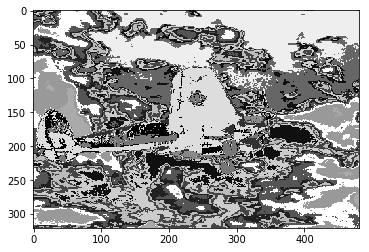

In [176]:
color(img, 16)

In [155]:
def half_disk(scales, orients):
    l

In [192]:
import numpy as np

a,b = 1,1
n=6
r=3

y,x = np.ogrid[-r:r, -r:r]
mask = x*x + y*y <= r*r

array = np.ones((n,n))
array[mask] = 255

In [197]:
y,x = np.ogrid[-3:3+1,-3:3+1]
mask = x**2 + y**2 <= 3**2

In [235]:
a = np.ones((12,12))

In [218]:
mask = 254*mask.astype(float)

In [219]:
from scipy.ndimage.filters import convolve
b = convolve(a,mask)-sum(sum(mask))+1

In [220]:
b

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])

In [494]:
import skimage.transform
def half_disk(radius):
    a=np.ones((2*radius+1,2*radius+1))
    y,x = np.ogrid[-radius:radius+1,-radius:radius+1]
    mask2 = x*x + y*y <= radius**2
    a[mask2] = 0
    b=np.ones((2*radius+1,2*radius+1))
    y,x = np.ogrid[-radius:radius+1,-radius:radius+1]
    p = x>-1 
    q = y>-radius-1
    mask3 = p*q
    b[mask3] = 0

    return a, b
scales = [5,7,9]            
def disk_masks(scales, orients):
    flt = list()
    orients = np.linspace(0,360,orients)
    for i in scales:
        radius = i
        g = list()
        a,b = half_disk(radius = radius)
        
        for i,eachOrient in enumerate(orients):
#             plt.figure(figsize=(16,2))
#             image=skimage.transform.rotate(,eachOrient)
            c = skimage.transform.rotate(b,eachOrient,cval =1)
            z = np.logical_or(a,c)
            g.append(z)
#           plt.imshow(c[0][3],cmap='binary')  
#             plt.subplot(radius,orients,i+1)
#             plt.imshow(c,cmap='binary')
#             plt.imshow(c,cmap = 'binary')
        flt.append(g)
    return flt        

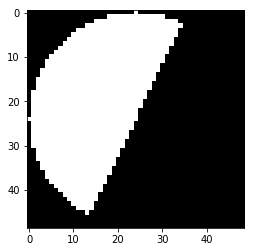

In [501]:
c = disk_masks([5,24], 8)
plt.imshow(c[1][3],cmap='binary')

In [498]:
orients = 8
orients = np.linspace(0,360,orients)

In [499]:
plt.imshowc[1][2]

AttributeError: 'module' object has no attribute 'imshowc'

In [413]:
a=np.ones((2*radius+1,2*radius+1))
y,x = np.ogrid[-radius:radius+1,-radius:radius+1]
mask2 = x*x + y*y <= radius**2
a[mask2] = 0

In [430]:
b = np.zeros((2*radius+1,2*radius+1),dtype = bool)
for i in range(2*radius+1):
    for j in range(radius):
        b[i,j] = 1
        
        
b=np.ones((2*radius+1,2*radius+1))
y,x = np.ogrid[-radius:radius+1,-radius:radius+1]
p = x>-1 
q = y>-radius-1
mask3 = p*q
b[mask3] = 0

b = skimage.transform.rotate(b,90)

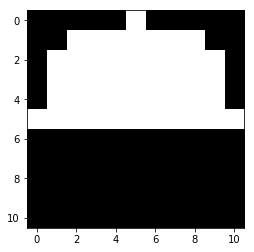

In [431]:
plt.imshow(np.logical_or(a,b),cmap='binary')

In [410]:
a

array([[1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0.]])